In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as ascii
import astropy.io.fits as pyfits
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output
%matplotlib notebook

## Funktioner

In [2]:
def power(time, signal, esignal, freqmin, freqmax, nfreq):
    """
    time: time for each observation
    signal: velocity (SONG) or magnitude (TESS)
    esignal: Error on signal
    freqmin: minimum frequency
    freqmax: maximum frequency
    nfreq: number of frequencies in [freqmin, freqmax] interval
    """
    fs  = np.linspace(freqmin,freqmax,nfreq)     #Her laves den cykliske frekvens
    nu  = 2*np.pi*fs                             #Her laves den angulære frekvens
    t   = time                                   #Sekunder siden tidseriens start
    signal = signal - np.median(signal)
    wt = 1/(esignal**2)
    
    alphas = np.zeros(len(fs))
    betas  = np.zeros(len(fs))
    
    Ps = np.zeros(len(fs))
    
    imax_fs = len(fs)
    
    for (i,f) in enumerate(fs):
        vt = nu[i]*t
        s  = np.sum(wt*signal*np.sin(vt))
        c  = np.sum(wt*signal*np.cos(vt))
        ss = np.sum(wt*np.sin(vt)**2)
        cc = np.sum(wt*np.cos(vt)**2)
        sc = np.sum(wt*np.sin(vt)*np.cos(vt))       
        
        alpha = (s*cc-c*sc)/(ss*cc-sc**2)
        beta  = (c*ss-s*sc)/(ss*cc-sc**2)
    
        P = alpha**2 + beta**2
        
        alphas[i] = alpha
        betas[i]  = beta
        Ps[i]     = P
    
    return Ps, fs, alphas, betas
    

In [3]:
def clean(signal, time, alpha, beta, P,frekvens,nfrekvens,f_init,f_max,nfreq):
    """
    signal: original data, radialhastighed (SONG) eller flux (TESS)
    time: tiden
    alpha: originale alpha
    beta: originale beta
    P: originale power
    frekvens: originale frekvens
    nfrekvens: antal gange en frekvens skal trækkes fra
    f_init: initial frequency
    f_max: max frequency
    nfreq: number of frequencies in [freqmin, freqmax] interval
    """
    
    output_list = []
    
    for i in range(nfrekvens):
        print(f'Clean {i+1}')
        P_max_test = np.where(P == np.max(P))
        alpha_max  = alpha[P_max_test][0]
        beta_max   = beta[P_max_test][0]
        f0         = frekvens[P_max_test][0]
        signal     = signal - alpha_max * np.sin(2 * np.pi * f0 * time) - beta_max * np.cos(2 * np.pi * f0 * time)
        
        P,frekvens,alpha,beta = power(time, signal,1,f_init,f_max,nfreq)
        
        output = {
            'signals': signal,
            'Ps': P,
            'fs': frekvens,
            'alphas': alpha,
            'betas': beta,
            'f0' : f0,
        }
        
        output_list.append(output)
    
    
    
    return output_list

## Importer data

In [4]:
t0 = 2457000.0
# TESS data
tess      = pyfits.getdata( 'TESS/gam_psc_tess.fits',1 )
tess_x    = tess['time']
tess_y    = tess['flux']
tt        = np.where( np.isnan( tess_y ) == False )[0]
tess_time = tess_x[tt]
tesstime2 = tess_x[tt]
tess_flux = tess_y[tt]
tessflux2 = tess_y[tt]
kk = np.where( (tess_flux < 1.12e7) & (tess_flux > 1.1e7) & (np.abs( tess_flux - np.roll( tess_flux, 1 ))  < 2400 ))[0]  #Bedste TESS
tess_fluxen = 25000.0*((tess_flux[kk] / np.median( tess_flux[kk]))-1)
tess_time   = tess_time[kk]
tess_sort   = np.where((tess_fluxen < 65) & (tess_fluxen > -65))
tess_flux   = tess_fluxen[tess_sort]
tess_time   = tess_time[tess_sort]
tess_sorted = np.where((tess_time < 2454) | (tess_time > 2456.59))  #stregen betyder eller
tess_flux   = tess_flux[tess_sorted]
tess_time   = tess_time[tess_sorted]
tess_timefinal = 86400.0 * (tess_time - np.median(tess_time))


# SONG OT
ot        = ascii.read( 'SONG/HIP114971_2022-02-02T094858.txt')
time_ot   = ot['col3']-t0
rv_ot     = ot['col5']  #+14480.0
timemask  = np.where(time_ot>2000)   #Finder de data der er samme tid med TESS og Mt Kent
time_ot_masked = time_ot[timemask]   #Liste med kun de data jeg skal bruge
rv_ot_masked   = rv_ot[timemask]     #Liste med kun de data jeg skal bruge
ii = np.where( (time_ot > 2400) & (np.abs( rv_ot - np.roll(rv_ot,1)   ) < 15.0) & (time_ot < 2540))[0]  #Bedste OT data
rv_ot = rv_ot-np.median(rv_ot)
rv_ot = rv_ot[ii]
time_ot = time_ot[ii]
time_otfinal = 86400.0 * (time_ot - np.median(time_ot))

cc     = np.polyfit( time_ot, rv_ot, 2 )
rv_ot  = rv_ot - np.polyval( cc, time_ot)

# SONG MtK
mk        = ascii.read( 'SONG/mtkent.txt' )
time_mk   = mk['col1']-t0
rv_mk     = mk['col2']-np.median(rv_ot)
jj = np.where( np.abs( rv_mk - np.roll(rv_mk,1)   ) < 33.0 )[0]  #Bedste Mt Kent data
cc_mk    = np.polyfit( time_mk[jj], rv_mk[jj], 2 )
rv_mk = rv_mk[jj] - np.polyval( cc_mk, time_mk[jj])
time_mk = time_mk[jj]
time_mkfinal = 86400.0 * (time_mk - np.median(time_mk))


<IPython.core.display.Javascript object>


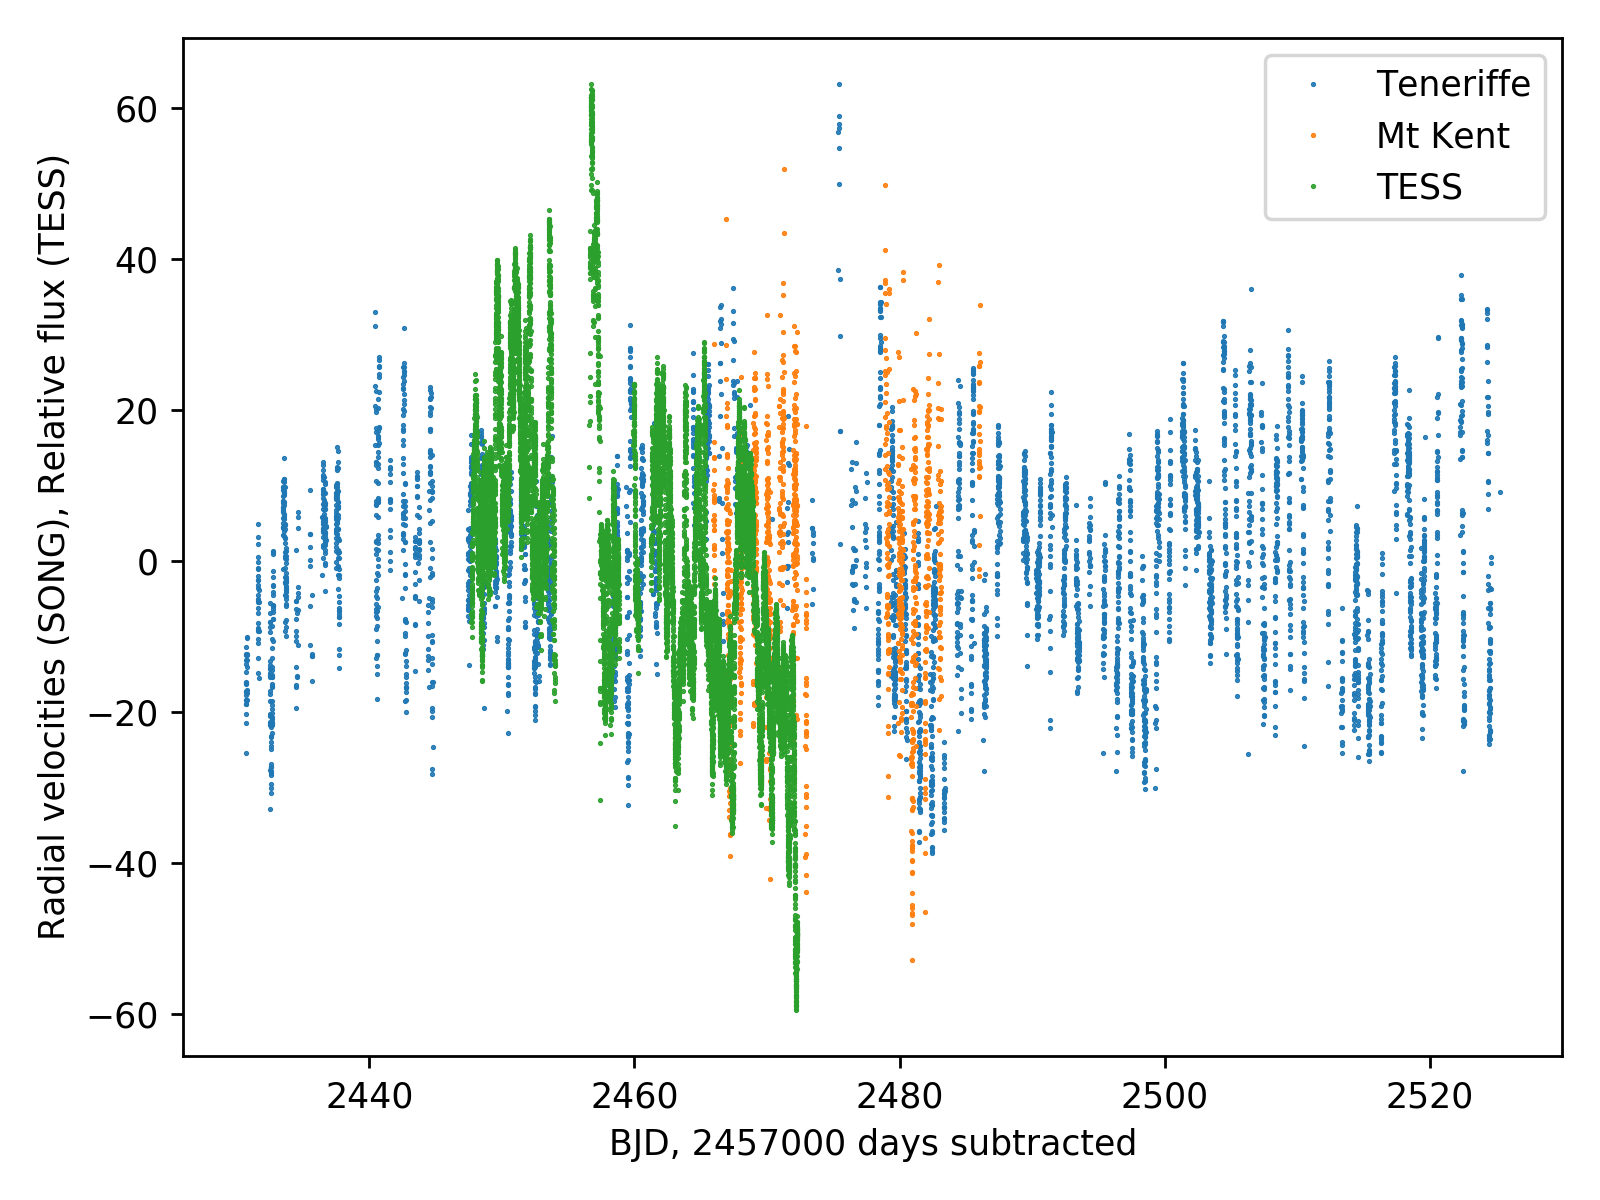

In [5]:
fig,ax = plt.subplots(1,1,tight_layout=True)
ax.set_xlabel('BJD, 2457000 days subtracted')
ax.set_ylabel('Radial velocities (SONG), Relative flux (TESS)')
ax.plot(time_ot, rv_ot,'o',ms=0.5,label='Teneriffe')
ax.plot(time_mk,rv_mk,'o',ms=0.5, label='Mt Kent')
ax.plot(tess_time,tess_flux,'o',ms=0.5,label='TESS')
ax.legend()

## Powerspectra

### Tenerife

In [6]:
finit_ot = 1e-6
fmax_ot  = 200*1e-6
err_ot   = 0.0*rv_ot + 1.0 
npt      = 20000

P_ot,f_ot,a_ot,b_ot = power(time_otfinal,rv_ot, err_ot, finit_ot, fmax_ot, npt)

In [7]:
#cleaning

ot_clean = clean(rv_ot,time_otfinal,a_ot,b_ot,P_ot,f_ot,50,finit_ot, fmax_ot, 20000)

Clean 1
Clean 2
Clean 3
Clean 4
Clean 5
Clean 6
Clean 7
Clean 8
Clean 9
Clean 10
Clean 11
Clean 12
Clean 13
Clean 14
Clean 15
Clean 16
Clean 17
Clean 18
Clean 19
Clean 20
Clean 21
Clean 22
Clean 23
Clean 24
Clean 25
Clean 26
Clean 27
Clean 28
Clean 29
Clean 30
Clean 31
Clean 32
Clean 33
Clean 34
Clean 35
Clean 36
Clean 37
Clean 38
Clean 39
Clean 40
Clean 41
Clean 42
Clean 43
Clean 44
Clean 45
Clean 46
Clean 47
Clean 48
Clean 49
Clean 50


<IPython.core.display.Javascript object>


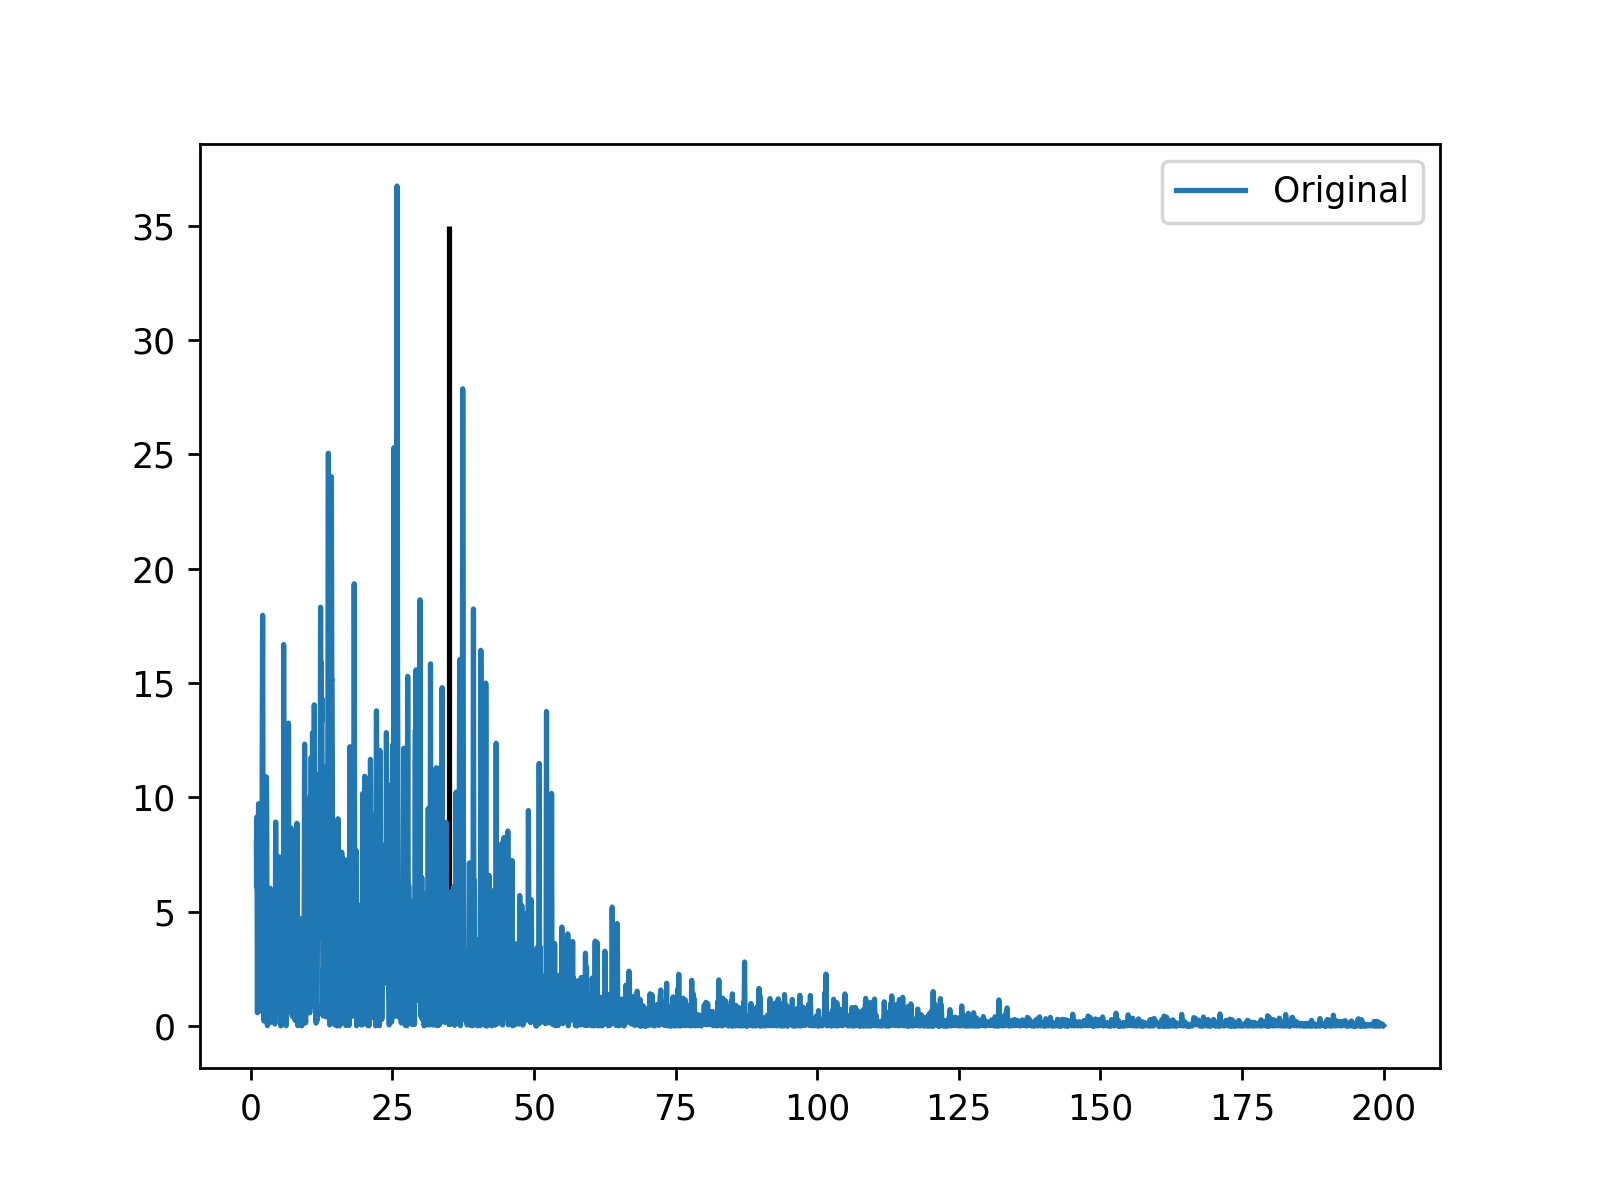

In [89]:
fig2,ax2 = plt.subplots(1,1)
ax2.plot(f_ot*1e6,P_ot, label = 'Original')
#ax2.plot(ot_clean[0]['fs']*1e6,ot_clean[0]['Ps'], label = '1st clean', alpha = 0.5)
#ax2.plot(ot_clean[-1]['fs']*1e6,ot_clean[-1]['Ps'], label = 'last clean', alpha = 0.5)
ax2.vlines(35,0.0,35)
ax2.legend()

In [9]:
f0_ot = np.zeros(50)
for i in np.arange(50): 
    f0_ot[i]=ot_clean[i]['f0']

### Mt Kent

In [10]:
finit_mk = 1e-6
fmax_mk  = 200*1e-6
err_mk   = 0.0*rv_mk + 1.0 
npt      = 20000

P_mk,f_mk,a_mk,b_mk = power(time_mkfinal,rv_mk, err_mk, finit_mk, fmax_mk, npt)

In [11]:
#cleaning

mk_clean = clean(rv_mk,time_mkfinal,a_mk,b_mk,P_mk,f_mk,50,finit_mk, fmax_mk, npt)

Clean 1
Clean 2
Clean 3
Clean 4
Clean 5
Clean 6
Clean 7
Clean 8
Clean 9
Clean 10
Clean 11
Clean 12
Clean 13
Clean 14
Clean 15
Clean 16
Clean 17
Clean 18
Clean 19
Clean 20
Clean 21
Clean 22
Clean 23
Clean 24
Clean 25
Clean 26
Clean 27
Clean 28
Clean 29
Clean 30
Clean 31
Clean 32
Clean 33
Clean 34
Clean 35
Clean 36
Clean 37
Clean 38
Clean 39
Clean 40
Clean 41
Clean 42
Clean 43
Clean 44
Clean 45
Clean 46
Clean 47
Clean 48
Clean 49
Clean 50


<IPython.core.display.Javascript object>


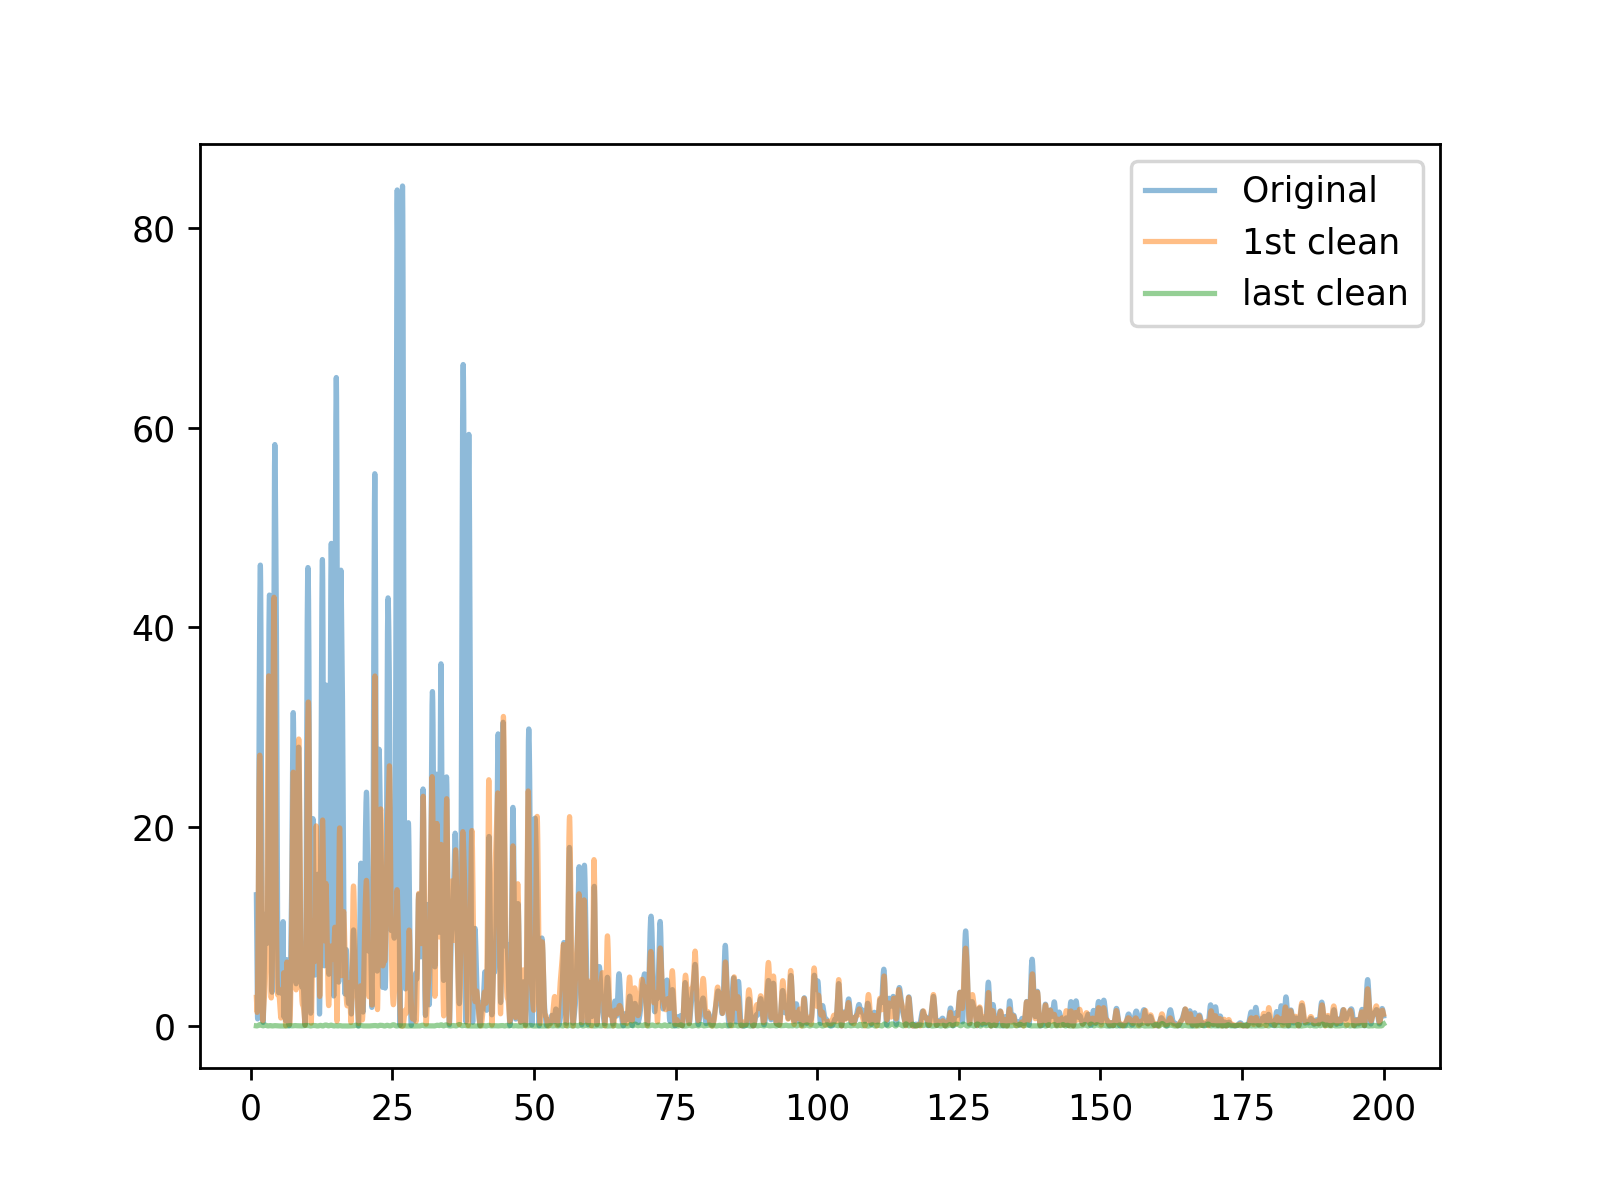

In [12]:
fig3,ax3 = plt.subplots(1,1)
ax3.plot(f_mk*1e6,P_mk, label = 'Original', alpha =0.5)
ax3.plot(mk_clean[0]['fs']*1e6,mk_clean[0]['Ps'], label = '1st clean', alpha = 0.5)
ax3.plot(mk_clean[-1]['fs']*1e6,mk_clean[-1]['Ps'], label = 'last clean', alpha = 0.5)
ax3.legend()

In [13]:
f0_mk = np.zeros(50)
for i in np.arange(50): 
    f0_mk[i]=mk_clean[i]['f0']

### Mt Kent & Tenerife combined

In [14]:
rv_SONG  = np.append( rv_mk, rv_ot )
time_SONG  = np.append( time_mkfinal, time_otfinal )
erv2 = 0.0 * rv_SONG + 1.0

P_SONG,f_SONG,a_SONG,b_SONG = power(time_SONG,rv_SONG,erv2,finit_ot,fmax_ot,npt)

In [15]:
#cleaning

SONG_cleaning = clean(rv_SONG,time_SONG,a_SONG,b_SONG,P_SONG,f_SONG,50,finit_ot,fmax_ot,npt)

Clean 1
Clean 2
Clean 3
Clean 4
Clean 5
Clean 6
Clean 7
Clean 8
Clean 9
Clean 10
Clean 11
Clean 12
Clean 13
Clean 14
Clean 15
Clean 16
Clean 17
Clean 18
Clean 19
Clean 20
Clean 21
Clean 22
Clean 23
Clean 24
Clean 25
Clean 26
Clean 27
Clean 28
Clean 29
Clean 30
Clean 31
Clean 32
Clean 33
Clean 34
Clean 35
Clean 36
Clean 37
Clean 38
Clean 39
Clean 40
Clean 41
Clean 42
Clean 43
Clean 44
Clean 45
Clean 46
Clean 47
Clean 48
Clean 49
Clean 50


<IPython.core.display.Javascript object>


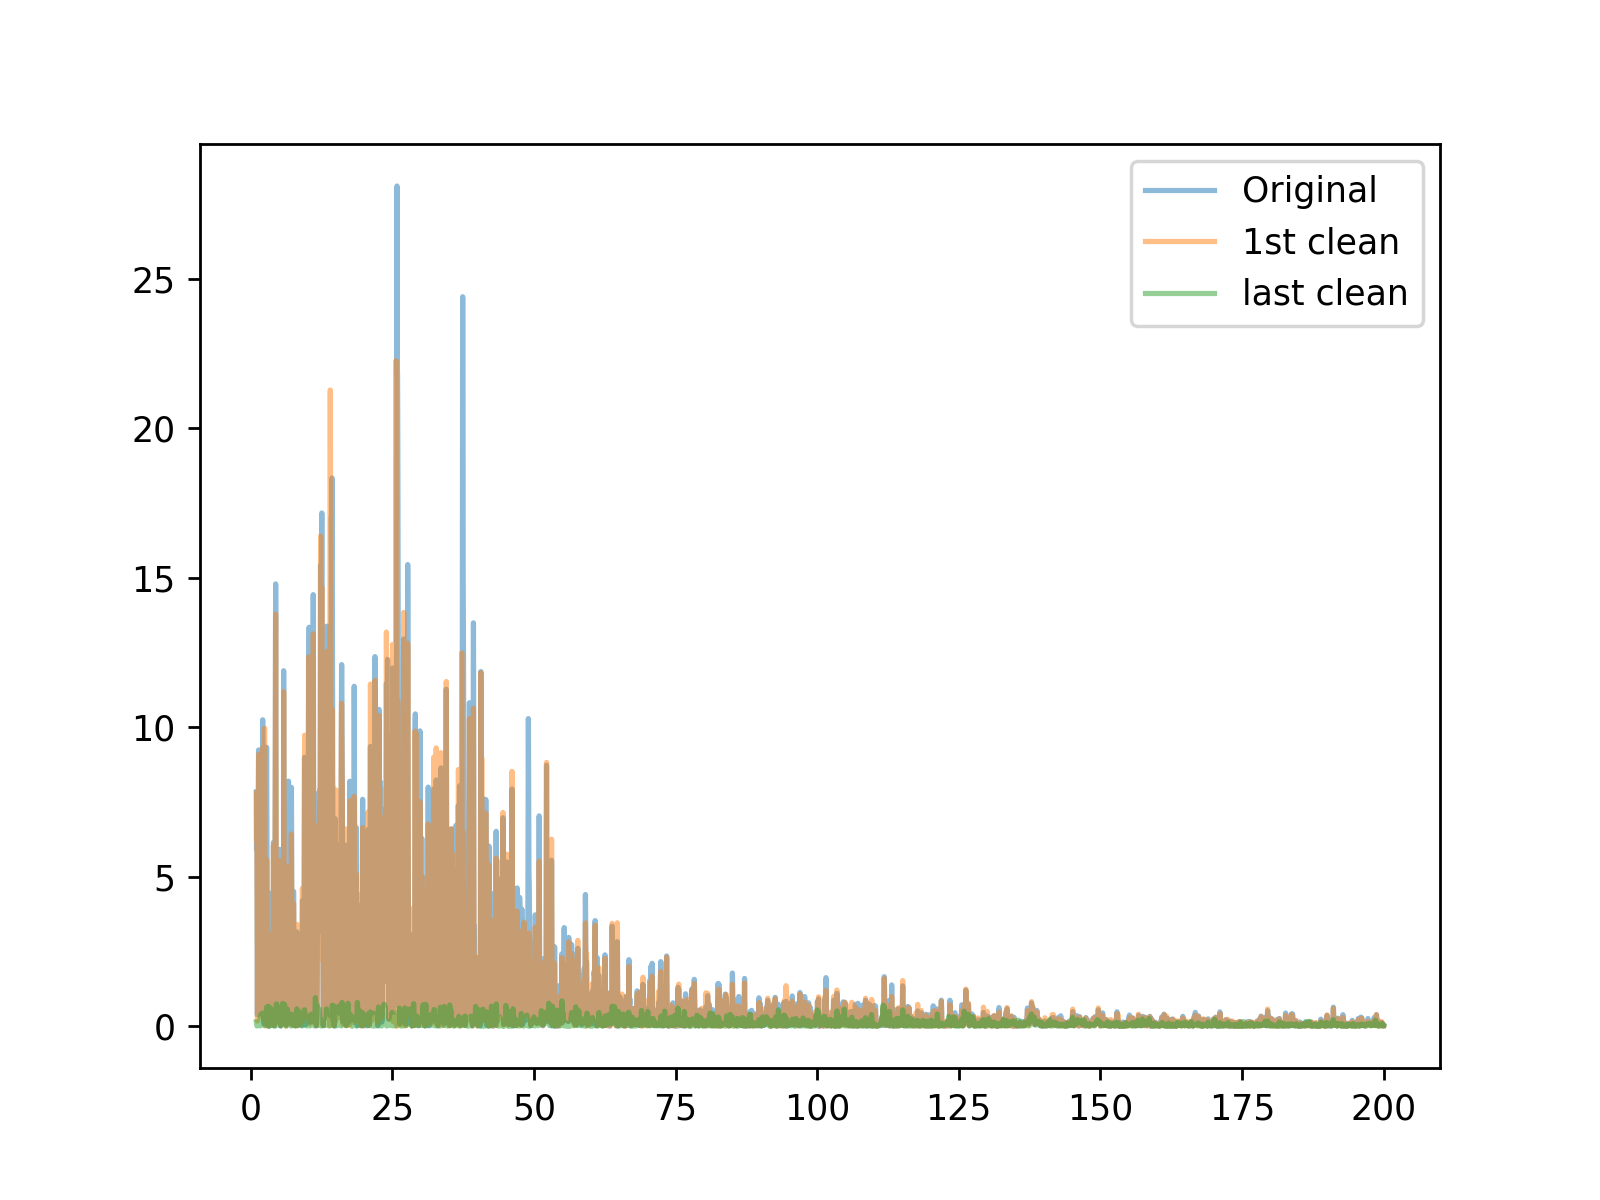

In [16]:
SONGfig,SONGax = plt.subplots(1,1)
SONGax.plot(f_SONG*1e6,P_SONG, label = 'Original', alpha =0.5)
SONGax.plot(SONG_cleaning[0]['fs']*1e6,SONG_cleaning[0]['Ps'], label = '1st clean', alpha = 0.5)
SONGax.plot(SONG_cleaning[-1]['fs']*1e6,SONG_cleaning[-1]['Ps'], label = 'last clean', alpha = 0.5)
SONGax.legend()

In [48]:
f0_SONG = np.zeros(50)
for i in np.arange(50): 
    f0_SONG[i]=SONG_cleaning[i]['f0']
    
f0_SONG

array([2.58264913e-05, 2.56473824e-05, 1.23336167e-05, 2.77270364e-05,
       5.81604080e-06, 3.45132757e-05, 1.19753988e-05, 1.38460923e-05,
       1.03037152e-05, 5.78618931e-06, 2.91798090e-05, 4.15084754e-05,
       1.25226761e-05, 3.17271364e-05, 4.01751088e-05, 3.21351068e-05,
       7.77628881e-06, 2.53090655e-05, 3.29311466e-05, 4.06427821e-05,
       1.10301015e-05, 2.59259963e-05, 1.76969348e-05, 2.97370369e-05,
       3.47620381e-05, 1.01942597e-05, 1.12291115e-05, 2.78066403e-05,
       3.62645632e-05, 1.96472324e-05, 7.16930847e-06, 4.95683784e-05,
       3.39958498e-05, 4.53792190e-05, 3.27866393e-06, 1.84531727e-05,
       3.31003050e-05, 2.12094605e-05, 2.51001050e-05, 2.73588679e-05,
       5.46232312e-05, 3.86725836e-05, 4.64936747e-05, 4.75185759e-05,
       3.07221361e-05, 5.06330817e-05, 1.24032702e-05, 1.79556478e-05,
       4.92300615e-05, 1.10945547e-06])

<IPython.core.display.Javascript object>


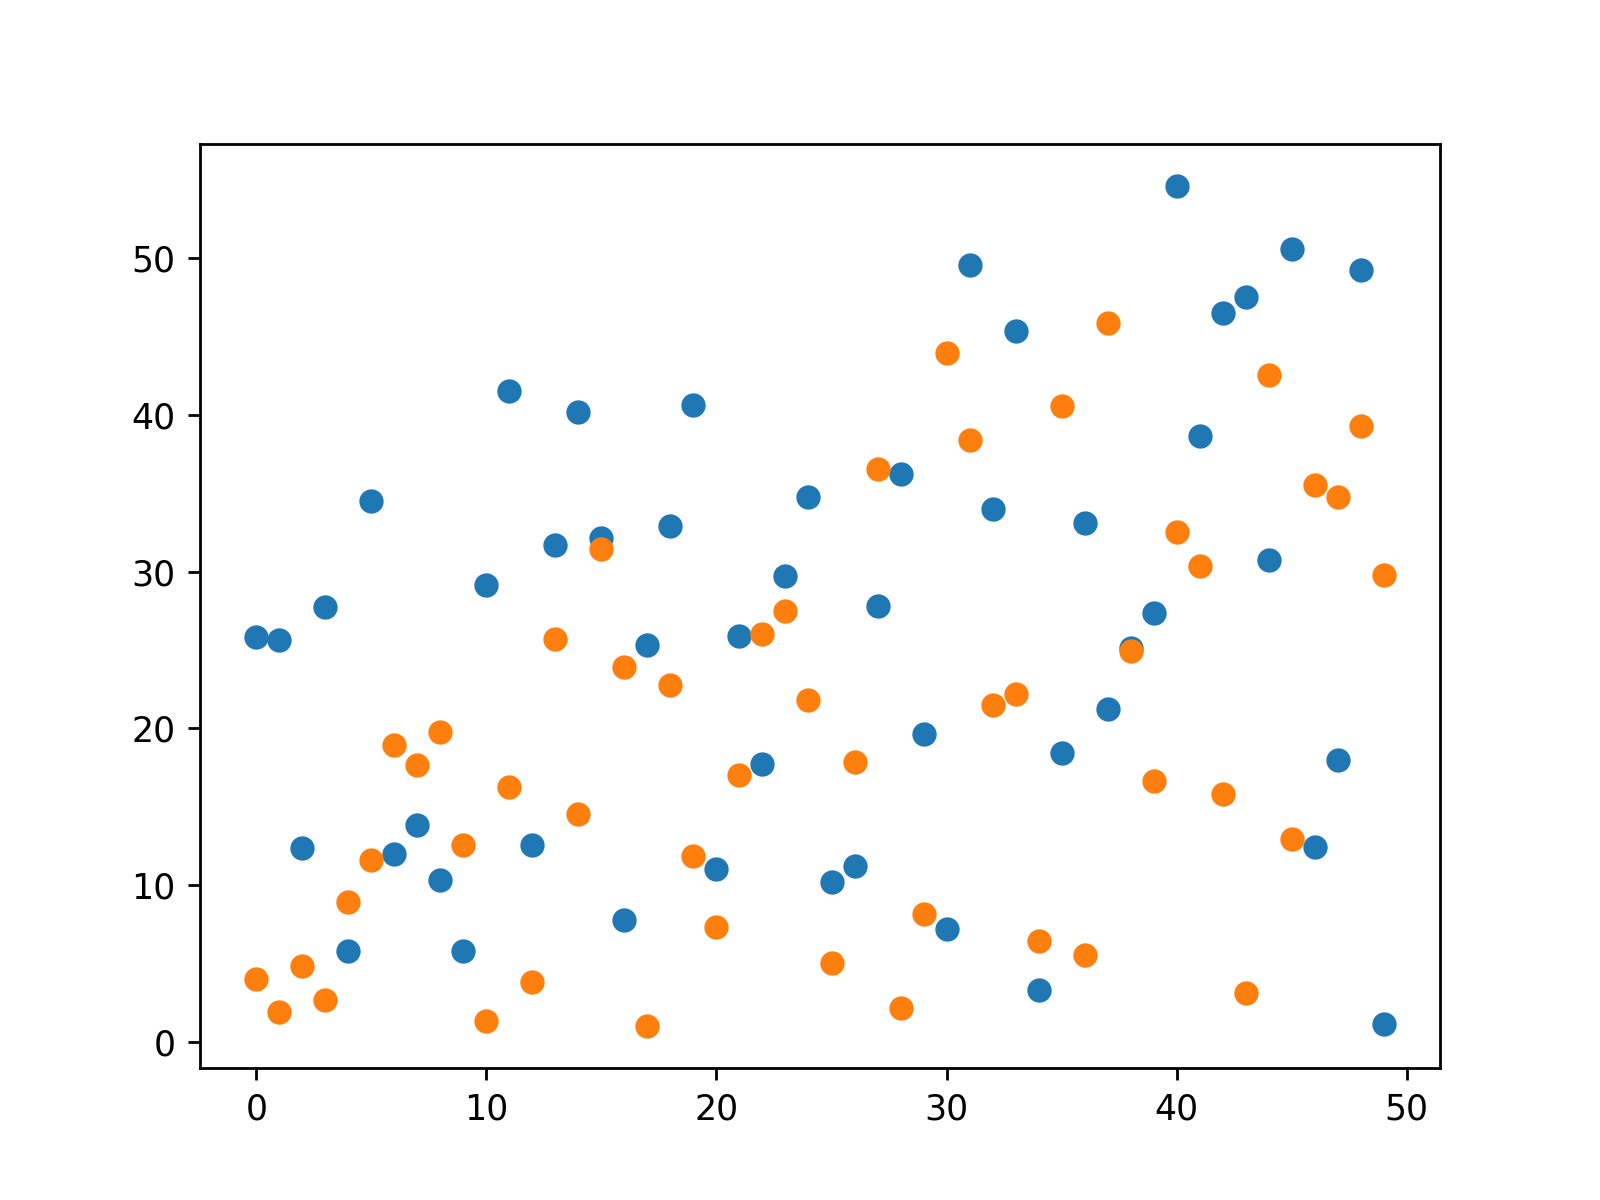

In [69]:
fig3,ax3 = plt.subplots(1,1)
ax3.plot(f0_SONG*1e6,'o')
ax3.plot(f0_TESS*1e6,'o')

### TESS

In [17]:
mag = 10.0-2.5*np.log10(tess_flux + 60)  #+60 for log10 ikke har et negativt input, er det lovligt?
cc_TESS = np.polyfit( tess_timefinal, mag, 2 )
fitmag  = np.polyval( cc_TESS, tess_timefinal )
err_tess = 0.0*mag+1.0

finit_tess = 1e-6
fmax_tess  = 200*1e-6 
npt      = 20000


P_TESS, f_TESS, a_TESS, b_TESS = power( tess_timefinal, mag - fitmag, err_tess, finit_tess, fmax_tess, npt )

In [18]:
#cleaning

tess_clean = clean(mag - fitmag, tess_timefinal, a_TESS, b_TESS, P_TESS, f_TESS, 50, finit_tess, fmax_tess, npt)

Clean 1
Clean 2
Clean 3
Clean 4
Clean 5
Clean 6
Clean 7
Clean 8
Clean 9
Clean 10
Clean 11
Clean 12
Clean 13
Clean 14
Clean 15
Clean 16
Clean 17
Clean 18
Clean 19
Clean 20
Clean 21
Clean 22
Clean 23
Clean 24
Clean 25
Clean 26
Clean 27
Clean 28
Clean 29
Clean 30
Clean 31
Clean 32
Clean 33
Clean 34
Clean 35
Clean 36
Clean 37
Clean 38
Clean 39
Clean 40
Clean 41
Clean 42
Clean 43
Clean 44
Clean 45
Clean 46
Clean 47
Clean 48
Clean 49
Clean 50


<IPython.core.display.Javascript object>


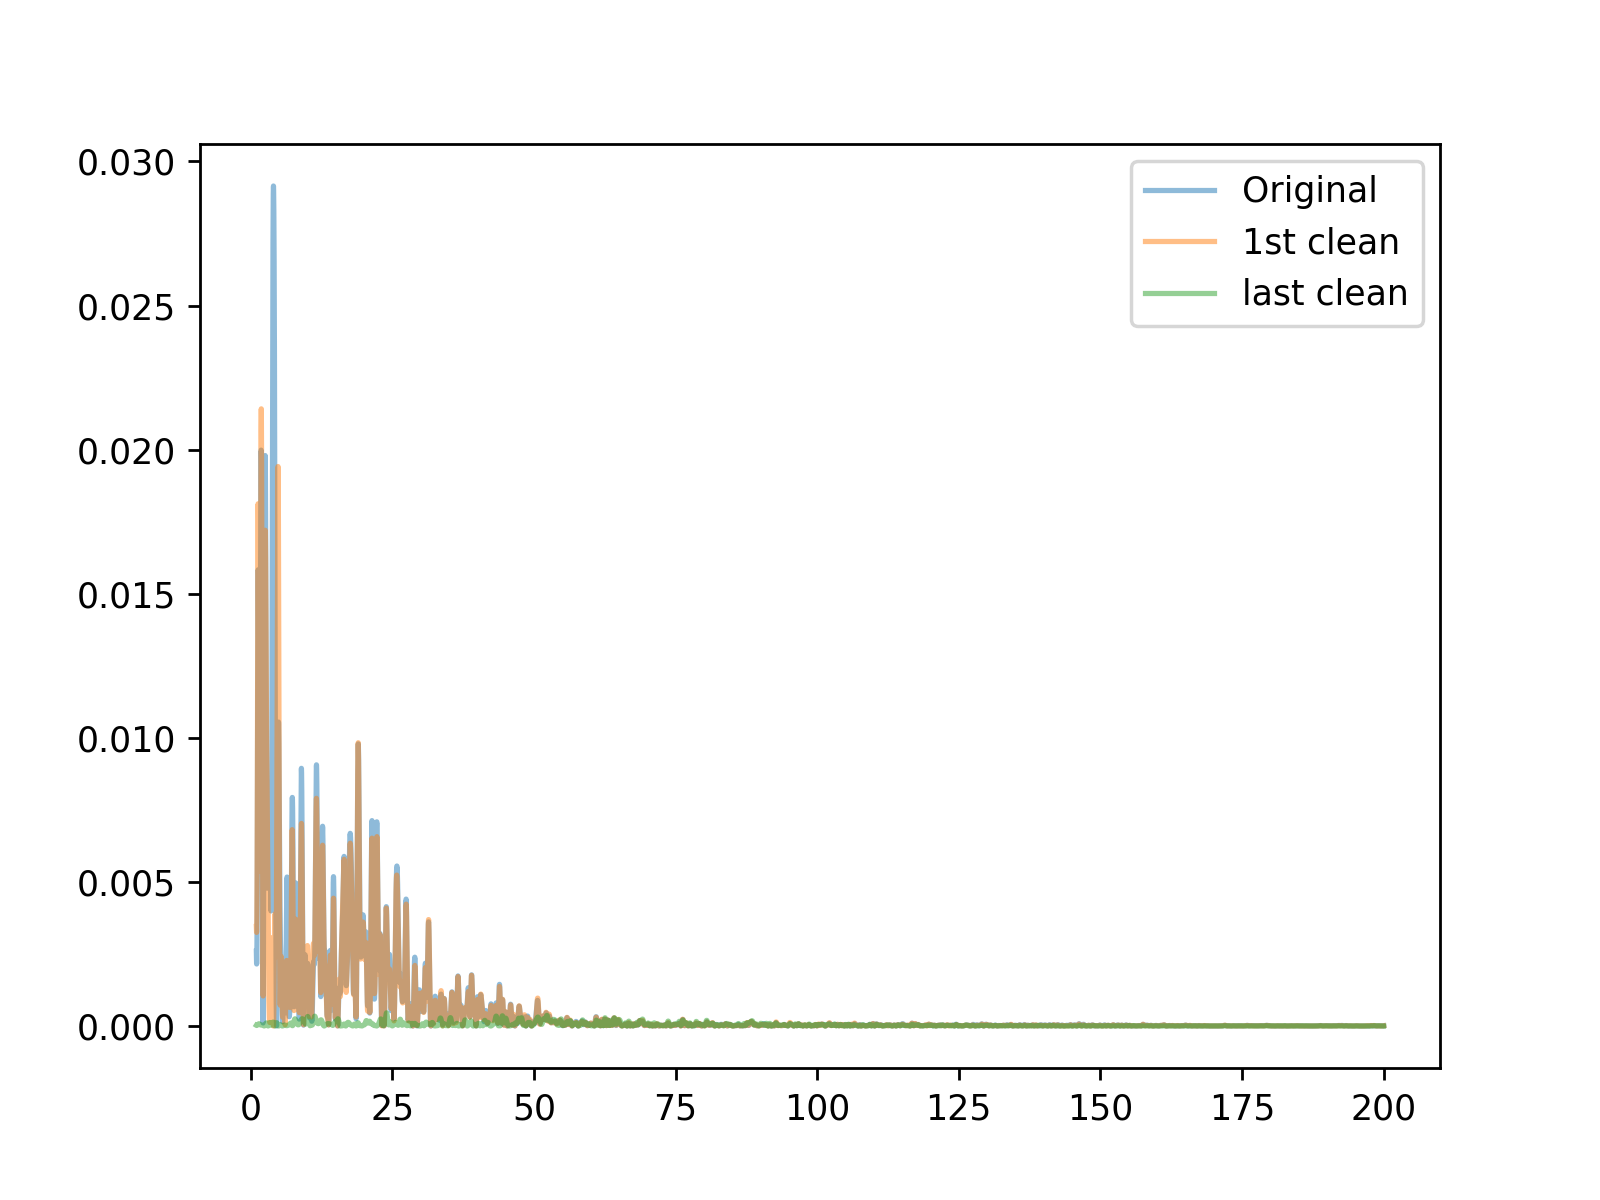

In [19]:
TESSfig,TESSax = plt.subplots(1,1)
TESSax.plot(f_TESS *1e6, P_TESS, label = 'Original', alpha =0.5 )
TESSax.plot(tess_clean[0]['fs']*1e6,tess_clean[0]['Ps'], label = '1st clean', alpha = 0.5)
TESSax.plot(tess_clean[-1]['fs']*1e6,tess_clean[-1]['Ps'], label = 'last clean', alpha = 0.5)
TESSax.legend()

In [54]:
f0_TESS = np.zeros(50)
for i in np.arange(50): 
    f0_TESS[i]=tess_clean[i]['f0']
    
f0_TESS

array([4.01500075e-06, 1.86569328e-06, 4.81104055e-06, 2.68163408e-06,
       8.94049702e-06, 1.15972799e-05, 1.89606480e-05, 1.76571329e-05,
       1.97666383e-05, 1.25624781e-05, 1.34826741e-06, 1.62342117e-05,
       3.81599080e-06, 2.57269863e-05, 1.45525776e-05, 3.14286214e-05,
       2.39060453e-05, 1.00000000e-06, 2.27517876e-05, 1.18460423e-05,
       7.29866493e-06, 1.70103505e-05, 2.59956498e-05, 2.74683234e-05,
       2.18064903e-05, 5.03990200e-06, 1.78561428e-05, 3.65730287e-05,
       2.17415871e-06, 8.12455623e-06, 4.39363968e-05, 3.83939697e-05,
       2.14681734e-05, 2.22244112e-05, 6.41307065e-06, 4.05930297e-05,
       5.50757538e-06, 4.58866943e-05, 2.49707485e-05, 1.66421821e-05,
       3.25430772e-05, 3.03639182e-05, 1.57963898e-05, 3.08960448e-06,
       4.25433272e-05, 1.29604980e-05, 3.55481274e-05, 3.47719886e-05,
       3.92895145e-05, 2.97768388e-05])

In [ ]:
#Autocorrelation, kan findes i python, tag kun mellem 15 og 45, specielt for TESS. 
#Hold øje med 11,57 (svarer til en dag)
#Smooth scipy nd image gaussian filter

## Auto correlation

### Tenerife

In [71]:
P_otsmooth = gaussian_filter(P_ot,sigma = 7)
acsort     = np.where((f_ot>15*1e-6)&(f_ot<45*1e-6))
P_otsmooth = P_otsmooth[acsort]

In [72]:
ot_ac = np.correlate(P_otsmooth, P_otsmooth, mode="full")

In [73]:
freq_shifts = np.linspace(-1,1,len(ot_ac)) * 15*1e-6

In [23]:
ncorrpointsl = np.linspace(1,len(P_otsmooth),num=len(P_otsmooth)-1,endpoint=False,dtype=int)
ncorrpointsr = np.linspace(len(P_otsmooth),1,num=len(P_otsmooth),dtype=int)
ncorrpoint   = np.append(ncorrpointsl,ncorrpointsr)

### Mt Kent

In [75]:
P_mksmooth = gaussian_filter(P_mk,sigma = 7)
acsort_mk     = np.where((f_mk>15*1e-6)&(f_mk<45*1e-6))
P_mksmooth = P_mksmooth[acsort_mk]

In [76]:
mk_ac = np.correlate(P_mksmooth, P_mksmooth, mode="full")

In [77]:
freq_shiftsmk = np.linspace(-1,1,len(mk_ac)) * 15*1e-6

### SONG combined

In [78]:
P_SONGsmooth = gaussian_filter(P_SONG,sigma = 7)
acsort_SONG     = np.where((f_SONG>15*1e-6)&(f_SONG<45*1e-6))
P_SONGsmooth = P_SONGsmooth[acsort_SONG]

In [79]:
SONG_ac = np.correlate(P_SONGsmooth, P_SONGsmooth, mode="full")

In [80]:
freq_shiftsSONG = np.linspace(-1,1,len(SONG_ac)) * 15*1e-6

### TESS

In [82]:
P_TESSsmooth = gaussian_filter(P_TESS,sigma = 7)
acsort_TESS  = np.where((f_TESS>15*1e-6)&(f_TESS<35*1e-6))
P_TESSsmooth = P_TESSsmooth[acsort_TESS]

In [83]:
TESS_ac = np.correlate(P_TESSsmooth, P_TESSsmooth, mode="full")

In [84]:
freq_shiftsTESS = np.linspace(-1,1,len(TESS_ac)) * (15-35)/2 *1e-6

### Plotted

<IPython.core.display.Javascript object>


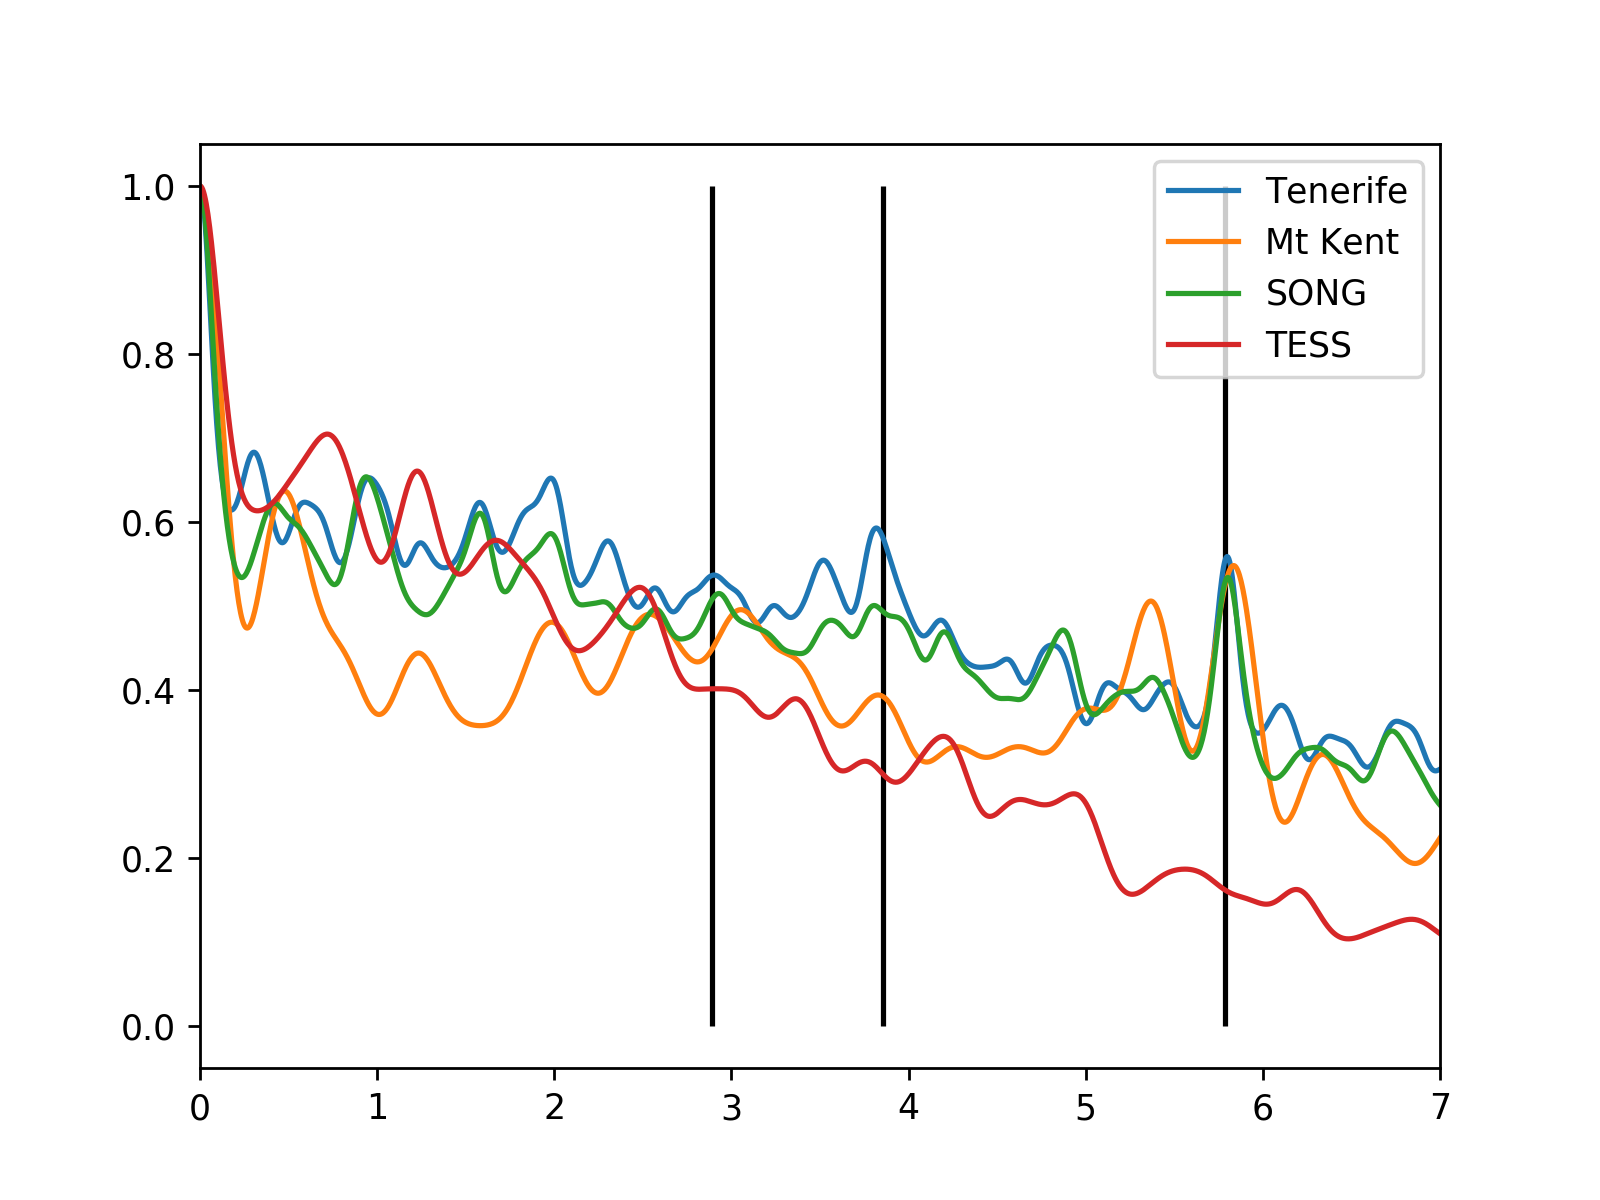

In [85]:
fig4,ax4 = plt.subplots(1,1)
ax4.set_xlim(0,7)
ax4.plot(freq_shifts*1e6,ot_ac/np.max(ot_ac), label='Tenerife')
ax4.plot(freq_shiftsmk*1e6,mk_ac/np.max(mk_ac), label='Mt Kent')
ax4.plot(freq_shiftsSONG*1e6,SONG_ac/np.max(SONG_ac), label='SONG')
ax4.plot(freq_shiftsTESS*1e6,TESS_ac/np.max(TESS_ac), label='TESS')
ax4.vlines(11.57/2,0.0,1)
ax4.vlines(11.57/3,0.0,1)
ax4.vlines(11.57/4,0.0,1)
ax4.legend()

<IPython.core.display.Javascript object>


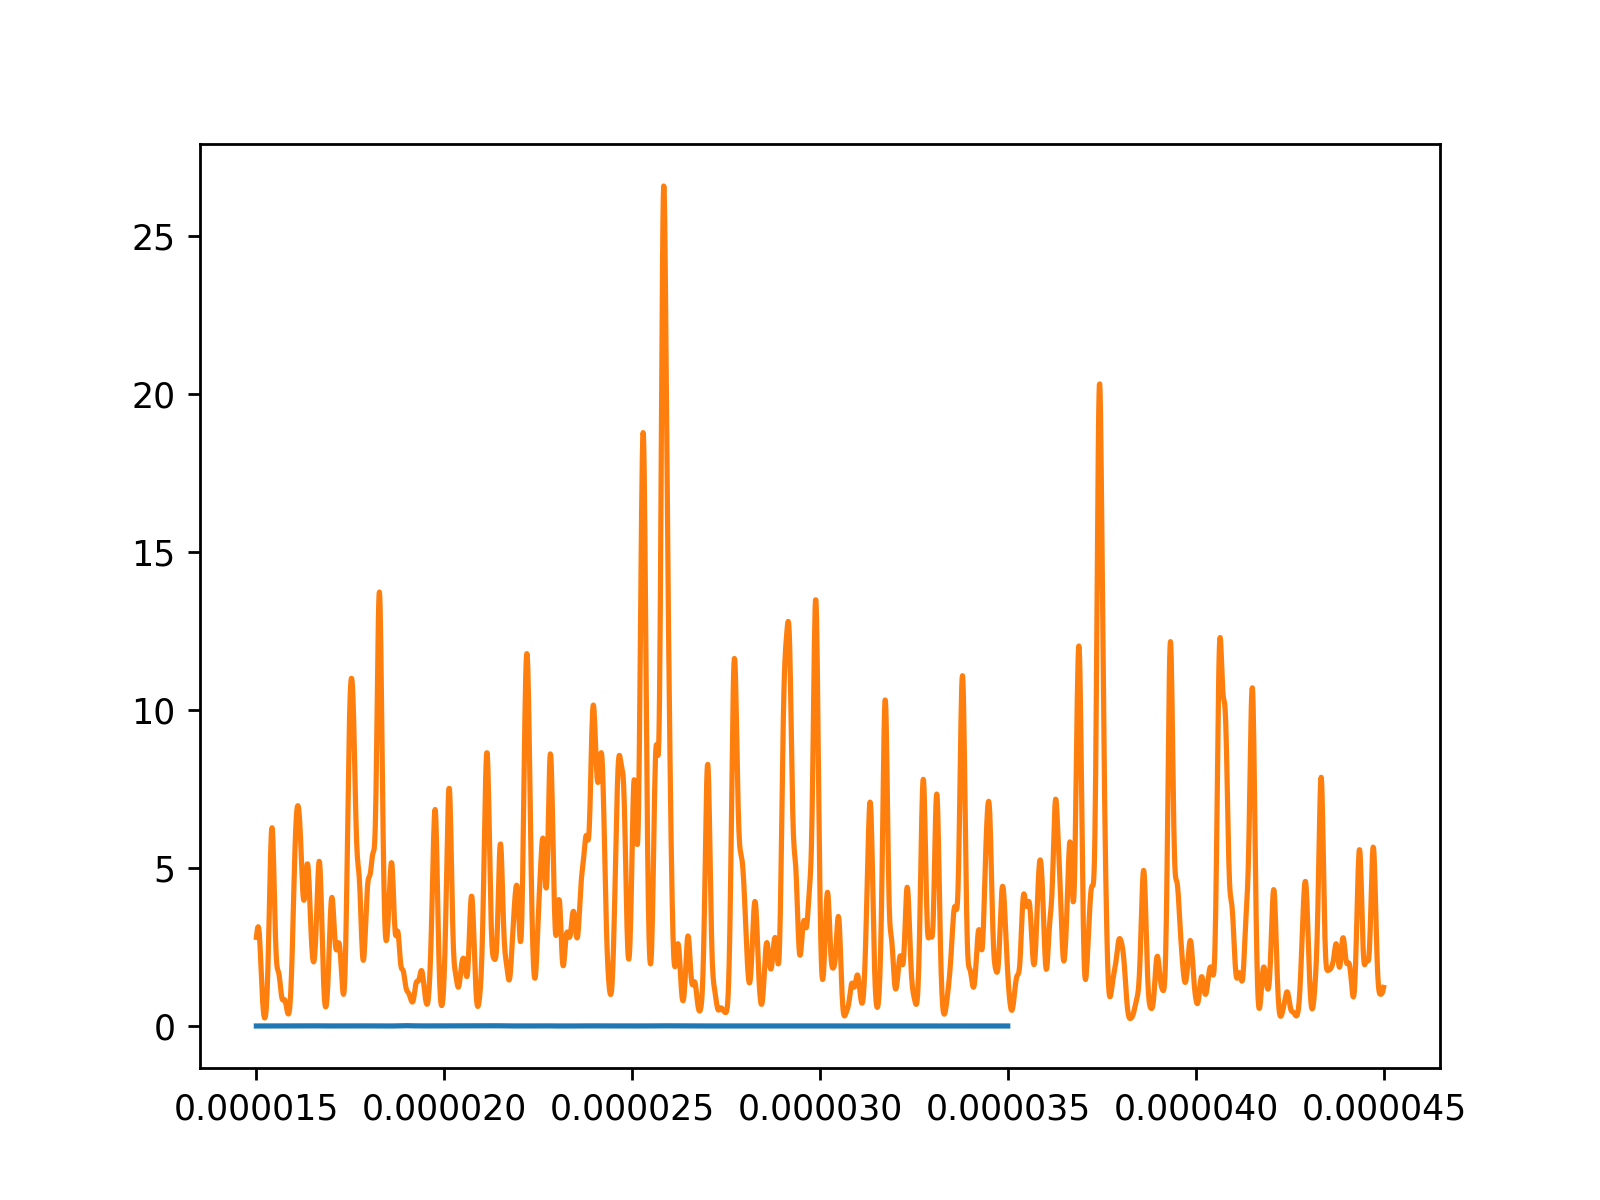

In [69]:
fig5,ax5 = plt.subplots(1,1)
ax5.plot(f_TESS[acsort_TESS],P_TESSsmooth)
ax5.plot(f_ot[acsort],P_otsmooth)

Til næste gang: find parametre, se billede.
vsini: hvor hurtigt den roterer

Hvad er SONG og TESS

Hvad skal der være med i rapporten